In [12]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

# Load mono scan

In [13]:
fc = FileChooser('/sf/alvra/data/p19262/raw/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [10]:
quantile_corr = 0.4

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)

(DataFluo, Izero, correlation, Energy_eV) = \
XAS_scan_1diode_static(fc.selected, detector_XAS, detector_Izero, quantile_corr)

/sf/alvra/data/p19262/raw/scan_info/036_RhacacCO2_RIXS.json

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   2002 / 2002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  2002 / 2002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 2002 / 2002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2002 / 2002 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
(800,) shots out of (2002,) survived
Step 101 of 101: Processed run_003224
correlation Diode (all shots) = 0.9970604647068729


<IPython.core.display.Javascript object>


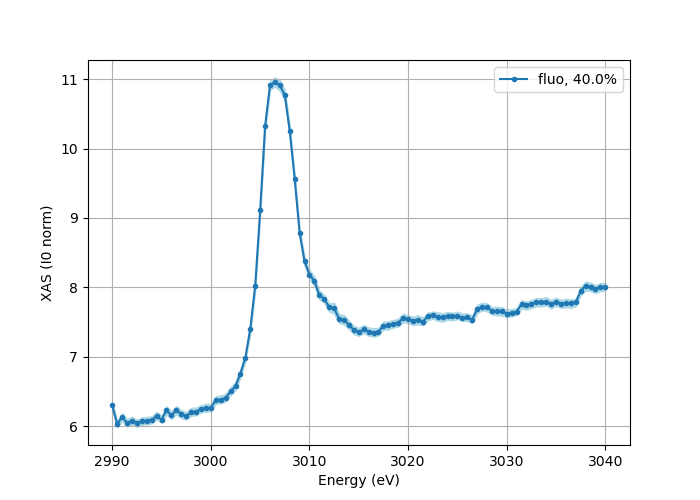

In [14]:
plt.figure(figsize = (7,5))

XAS = DataFluo[:,0]
err_low = DataFluo[:,1]
err_high = DataFluo[:,2]

plt.plot(Energy_eV, XAS, label='{}, {}%'.format('fluo', quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low, err_high, color='lightblue')

#plt.plot(Energy_eV, (XAS2-XAS2[0])/sum(XAS2-XAS2[0]), label='{}, {}%'.format('APD2', quantile_corr*100),marker='.')
#plt.fill_between(Energy_eV, err_low2, err_high2, color='navajowhite')


plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.title(fc.selected_filename, fontsize=12)
plt.grid()

plt.show()

#plt.savefig(savedir+'/XANES_RhAcac.png')

In [23]:
np.save(savedir+'XAS_Rhacac', XAS)

In [21]:
savedir = '/das/work/p19/p19262/Export/'
os.makedirs(savedir, exist_ok=True)
print (savedir)

/das/work/p19/p19262/Export/


## Check correlation for a certain energy point

In [8]:
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

chosen_energy = 3007

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

quantile_corr = 0.2
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)

index_energy = np.arange(len(Energy_eV))[(Energy_eV > chosen_energy)][0]

(Fluo, Izero, Fluo_filter, Izero_filter) = \
Get_correlation_from_scan_static(scan, index_energy, detector_XAS, detector_Izero, quantile_corr)

print ('Energy = {} eV'.format(Energy_eV[index_energy]))

(400,) shots out of (2002,) survived
Energy = 3007.0067055440554 eV


<IPython.core.display.Javascript object>


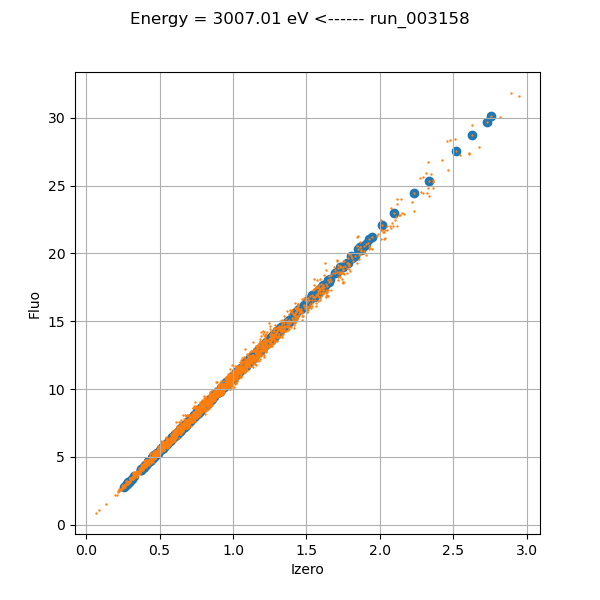

In [9]:
plt.figure(figsize=(6,6))
plt.suptitle('Energy = {:.2f} eV <------ {}'.format(Energy_eV[index_energy], scan.files[index_energy][1].split('/')[-1].split('.')[0]))
plt.scatter(Izero_filter, Fluo_filter)
plt.scatter(Izero, Fluo, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo')
plt.grid()
plt.show()